# 扰动信号分类

## 构建一维CNN实现四类信号识别

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Activation, Conv1D, Add, Multiply, BatchNormalization, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
# 加载数据集
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []
with open('train_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_train.append([int(x) for x in temp])
with open('val_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_val.append([int(x) for x in temp])
with open('test_data.txt','r') as f:
    for line in f:
        temp = line.strip().split(',')
        X_test.append([int(x) for x in temp])
with open('train_label.txt','r') as f:
    for line in f:
        Y_train.append(line.strip())
with open('val_label.txt','r') as f:
    for line in f:
        Y_val.append(line.strip())
with open('test_label.txt','r') as f:
    for line in f:
        Y_test.append(line.strip())
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
Y_train, Y_val, Y_test = np.array(Y_train), np.array(Y_val), np.array(Y_test)

In [3]:
# 升维
X_train, X_val, X_test = np.expand_dims(X_train,axis = 1),np.expand_dims(X_val,axis = 1),np.expand_dims(X_test,axis = 1)
Y_train, Y_val, Y_test = np.expand_dims(Y_train,axis = 1),np.expand_dims(Y_val,axis = 1),np.expand_dims(Y_test,axis = 1)

In [4]:
batch_size = 32

def batch_generator(x, y, batch_size=batch_size): 
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            x, y = shuffle(x, y)
            offset = batch_size
            
        X_batch = x[offset - batch_size: offset]    
        Y_batch = y[offset - batch_size: offset]
        
        yield (X_batch, Y_batch)

In [5]:
epochs = 10
num_blocks = 3
filters = 64
drop_rate = 0.5
num_class = 4

X = Input(shape=(1,3800), dtype='float32')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'relu')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'relu')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'relu')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'relu')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu') # batch_size, seq_len, filters
h1 = batchnorm(conv1d(h1, num_class, 1, 1)) # batch_size, seq_len, num_class
h1 = GlobalMaxPooling1D()(h1) # batch_size, num_class
Y = activation(h1, 'softmax')

optimizer = Adam(lr=0.01, clipnorm=5)
model = Model(inputs=X, outputs=Y)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='zhuhai.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_val, Y_val), 
    validation_steps=len(X_val) // batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/10


W1205 07:31:36.771817 140190377809728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1205 07:32:08.249393 140190377809728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


52/52 [==============================] - 82s 2s/step - loss: 0.4546 - accuracy: 0.8816 - val_loss: 8.0258 - val_accuracy: 0.2500
Epoch 2/10
52/52 [==============================] - 8s 145ms/step - loss: 0.1820 - accuracy: 0.9718 - val_loss: 0.4676 - val_accuracy: 0.8062
Epoch 3/10
52/52 [==============================] - 7s 142ms/step - loss: 0.1578 - accuracy: 0.9694 - val_loss: 0.5444 - val_accuracy: 0.8062
Epoch 4/10
52/52 [==============================] - 7s 142ms/step - loss: 0.0940 - accuracy: 0.9850 - val_loss: 0.3208 - val_accuracy: 0.9062
Epoch 5/10
52/52 [==============================] - 7s 141ms/step - loss: 0.0675 - accuracy: 0.9880 - val_loss: 0.0398 - val_accuracy: 0.9875
Epoch 6/10
52/52 [==============================] - 7s 142ms/step - loss: 0.0674 - accuracy: 0.9874 - val_loss: 0.3443 - val_accuracy: 0.8875
Epoch 7/10
52/52 [==============================] - 7s 143ms/step - loss: 0.0304 - accuracy: 0.9970 - val_loss: 0.0488 - val_accuracy: 0.9875
Epoch 8/10
52/52 [=

## 对比训练集与验证集的loss及准确率变化

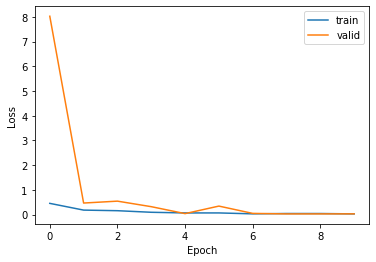

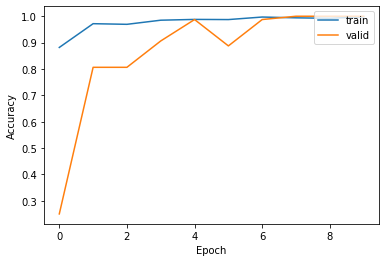

In [6]:
# 损失函数变化曲线
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 在测试集上验证

In [8]:
# 准确率
print('训练集loss为{}，准确率为{}'.format(history.history['loss'][-1], history.history['accuracy'][-1]))
print('验证集loss为{}，准确率为{}'.format(history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
score = model.evaluate(X_test, Y_test, verbose=0)
print('测试集loss为{}，准确率为{}'.format(score[0], score[1]))

训练集loss为0.029167114989832044，准确率为0.9975961446762085
验证集loss为0.0305146723985672，准确率为1.0
测试集loss为0.033884770986510486，准确率为1.0


In [9]:
# 对测试集任一信号进行分类
num = 34
prediction = model.predict(np.expand_dims(X_test[num],axis=0))
prediction = np.argmax(prediction, axis=1)[0]
label = ['noraml','foot','hand','stick']
print('预测结果是{}，其标签为{}'.format(label[prediction], label[int(Y_test[num][0])))

预测结果是3，其标签为3


## 保存训练好的模型

In [13]:
# 保存模型
model.save('DVS.h5')
model.save_weights('DVS_weights.h5')

## 模型格式转换
1. 模型之后需要通过C++调用，C++有tensorflow接口，但是没有keras接口，因此需要将h5模型转换为pb模型。
2. 关于C++使用pb模型，可以参考[C++调用pb文件](https://blog.csdn.net/wiscol/article/details/96492296)

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend
import os

In [12]:
def h52pb(h5_model,output_dir, model_name, out_prefix="output_", log_tensorboard=True):
    """.h5模型文件转换成pb模型文件
    Argument:
        h5_model: str
            .h5模型文件
        output_dir: str
            pb模型文件保存路径
        model_name: str
            pb模型文件名称
        out_prefix: str
            根据训练，需要修改
        log_tensorboard: bool
            是否生成日志文件
    Return:
        pb模型文件
    """
    if os.path.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i], out_prefix + str(i + 1))
    sess = backend.get_session()
 
    from tensorflow.python.framework import graph_util, graph_io
    # 写入pb模型文件
    init_graph = sess.graph.as_graph_def()
    main_graph = graph_util.convert_variables_to_constants(sess, init_graph, out_nodes)
    graph_io.write_graph(main_graph, output_dir, name=model_name, as_text=False)
    # 输出日志文件
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(os.path.join(output_dir, model_name), output_dir)

In [ ]:
if __name__ == '__main__':

    #  .h模型文件路径参数
    input_path = './'
    h5_file = 'DVS.h5'
    h5_file_path = os.path.join(input_path, h5_file)
    output_graph_name = h5_file[:-3] + '.pb'
 
    #  pb模型文件输出输出路径
    output_dir = os.path.join(os.getcwd(), "./")
 
    #  加载模型
    h5_model = load_model(h5_file_path)
    h52pb(h5_model, output_dir=output_dir, model_name=output_graph_name)
    print('Finished')